# <span style="color:teal"> Deep Reinforcement with $Improvised^1$ Architecture for</span> <span style="color:red">Atari Enduro-v0 </span>

### Import Required Packages

In [1]:
from __future__ import division

import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Permute
from keras.layers import Input, Conv2D
from keras.optimizers import Adam
from keras.activations import  linear

from keras.layers.advanced_activations import LeakyReLU

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor

Using TensorFlow backend.


***
### Enduro-v0 Environment

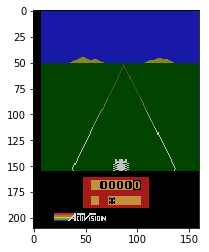

In [2]:
env = gym.make('Enduro-v0')

plt.imshow(env.render(mode='rgb_array'))

#### 1. *Number of possible action*

In [3]:
nb_actions = env.action_space.n
print('Total number of Possible actoin is :', nb_actions)

Total number of Possible actoin is : 9


#### 2. *Taking stack of 4 consecutive frames*

In [4]:
frame_shape = (84, 84)
window_length = 4
input_shape = (window_length,) + frame_shape
print('Input Shape is :', input_shape)

Input Shape is : (4, 84, 84)


***
### Defining class for pre-processing the game_frames

In [5]:
class GameProcess(Processor):
    def process_observation(self, observation):
        img = Image.fromarray(observation)
        img = np.array(img.resize(frame_shape).convert('L'))
        return img.astype('uint8')  

    def process_state_batch(self, batch):
        Processed_batch = batch.astype('float32') / 255.
        return Processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

***
## Improvised Architecture

In [6]:
def fire_incept(x, fire=16, intercept=64):
    x = Conv2D(fire, (4,4), strides=(2,2))(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    left = Conv2D(intercept, (3,3), padding='same')(x)
    left = LeakyReLU(alpha=0.1)(left)
    
    right = Conv2D(intercept, (5,5), padding='same')(x)
    right = LeakyReLU(alpha=0.1)(right)
    
    x = concatenate([left, right], axis=3)
    return x

def fire_squeeze(x, fire=16, intercept=64):
    x = Conv2D(fire, (1,1))(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    left = Conv2D(intercept, (1,1))(x)
    left = LeakyReLU(alpha=0.1)(left)
    
    right = Conv2D(intercept, (3,3), padding='same')(x)
    right = LeakyReLU(alpha=0.1)(right)
    
    x = concatenate([left, right], axis=3)
    return x

In [7]:
game_input=Input(shape=input_shape)

x = Permute((2, 3, 1))(game_input)

x = Conv2D(32, (8,8), strides=(4, 4))(x)
x = LeakyReLU(alpha=0.1)(x)

x = fire_incept(x, fire=64, intercept=32)

x = fire_squeeze(x, fire=64, intercept=32)

x = Conv2D(64, (3,3))(x)
x = LeakyReLU(alpha=0.1)(x)

x = Flatten()(x)

x = Dense(512)(x)
x = LeakyReLU(alpha=0.1)(x)

out = Dense(nb_actions, activation='linear')(x)

model_new = Model(game_input, out)
model_new.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 4, 84, 84)     0                                            
____________________________________________________________________________________________________
permute_1 (Permute)              (None, 84, 84, 4)     0           input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 20, 20, 32)    8224        permute_1[0][0]                  
____________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)        (None, 20, 20, 32)    0           conv2d_1[0][0]                   
___________________________________________________________________________________________

***
### Configuring the Agent

#### 1. Allocating memory for experience replay

In [8]:
Memory = SequentialMemory(limit=1000000, window_length=window_length)

#### 2.Policy: Epsilon Greedy Exploration
<span style="color:teal">*Gradually exploration will be decreased*</span>

In [9]:
Policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05, nb_steps=1000000)

#### 3. Compiling DQN Agent <span style="color:Red">with epsilon-greedy Exploration</span>

In [10]:
Dqn = DQNAgent(model=model_new, nb_actions=nb_actions, policy=Policy, memory=Memory, processor=GameProcess(),
               nb_steps_warmup=50000, gamma=.99, target_model_update=10000, train_interval=4, delta_clip=1.)

In [11]:
Dqn.compile(Adam(lr=.00025), metrics=['mae'])

## <span style="color:teal"> Training the model </span>

#### 1. For 2M Steps

History2M = Dqn.fit(env, nb_steps=2000000)

#### 2 Compile the DQN Agent with <span style="color:Red">No Exploration</span>

In [12]:
Dqn = DQNAgent(model=model_new, nb_actions=nb_actions, policy=None, memory=Memory, processor=GameProcess(),
               gamma=.99, target_model_update=10000, train_interval=4, delta_clip=1.)

Dqn.compile(Adam(lr=0.00025), metrics=['mae'])

#### 2.3 Fit for 1M Steps

History3M = Dqn.fit(env, nb_steps=1000000)

***
## <span style="color:teal"> Testing the model </span>

#### 1. Resetting the environment for Testing after <span style="color:red">**-  -   2M steps    -  -**</span>

In [13]:
Dqn.load_weights('dqn_New_2M.h5f')

In [14]:
np.random.seed(133)
env.seed(133)
env.reset()
Dqn.test(env, nb_episodes=5, visualize=False)

Testing for 5 episodes ...
Episode 1: reward: 160.000, steps: 4441
Episode 2: reward: 327.000, steps: 8854
Episode 3: reward: 332.000, steps: 8819
Episode 4: reward: 355.000, steps: 8882
Episode 5: reward: 180.000, steps: 4429


#### 3. Again Reseting the environment for Testing after  <span style="color:red">**-  -   3M steps    -  -**</span>

In [15]:
Dqn.load_weights('dqn_New_3M.h5f')

In [16]:
np.random.seed(133)
env.seed(133)
env.reset()
test_history = Dqn.test(env, nb_episodes=5, visualize=False)

Testing for 5 episodes ...
Episode 1: reward: 396.000, steps: 8853
Episode 2: reward: 148.000, steps: 4442
Episode 3: reward: 351.000, steps: 8819
Episode 4: reward: 402.000, steps: 8882
Episode 5: reward: 421.000, steps: 8866


In [17]:
average_reward = np.mean(test_history.history['episode_reward'])

average_steps = np.mean(test_history.history['nb_steps'])

'For 5 Episodes :: Averages Reward : ' + str(average_reward) + ' with average Steps played for : ' + str(int(average_steps))

'For 5 Episodes :: Averages Reward : 343.6 with average Steps played for : 7972'

In [18]:
# Trained on: Intel® Xeon® Processor E5, 2.40 GHz, Nvidia Quadro K4200
# Bhartendu Thakur, Machine Learning & Computing
# https://in.mathworks.com/matlabcentral/profile/authors/10083740-bhartendu?&detail=fileexchange
# https://in.linkedin.com/in/bhartendu-thakur-56bb6285